In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import re
from matplotlib.ticker import FuncFormatter

pd.set_option('display.max_columns', None)

In [2]:
WORKING_DIRECTORY = '../data/'

## Basic data validation

In [3]:
conn = sqlite3.Connection(WORKING_DIRECTORY + '/processed/fire_data.db')

Here we want to use CITY, STATE, INCIDENT KEY, INC_DATE, and INC_TYPE. We'll check the number of null values in these columns for incident_address and basic_incident.

In [4]:
display(pd.read_sql("""
    SELECT 
        COUNT(*) - COUNT(CITY) AS CITY_NULL,
        COUNT(*) - COUNT(STATE) AS STATE_NULL,
        COUNT(*) - COUNT(INCIDENT_KEY) AS INCIDENT_KEY_NULL,
        COUNT(*) - COUNT(INC_DATE) AS INC_DATE_NULL
    FROM incident_address;
""", conn))

display(pd.read_sql("""
    SELECT 
        COUNT(*) - COUNT(INCIDENT_KEY) AS INCIDENT_KEY_NULL,
        COUNT(*) - COUNT(INC_DATE) AS INC_DATE_NULL,
        COUNT(*) - COUNT(INC_TYPE) AS INC_TYPE_NULL
    FROM basic_incident;
""", conn))

,CITY_NULL,STATE_NULL,INCIDENT_KEY_NULL,INC_DATE_NULL
0,8560,1990,0,0


,INCIDENT_KEY_NULL,INC_DATE_NULL,INC_TYPE_NULL
0,0,0,0


Check the types of incident codes in the dataset.

In [5]:
query = """
    SELECT
        CASE
            WHEN INC_TYPE BETWEEN 100 AND 199 THEN '100-199'
            WHEN INC_TYPE BETWEEN 200 AND 299 THEN '200-299'
            WHEN INC_TYPE BETWEEN 300 AND 399 THEN '300-399'
            WHEN INC_TYPE BETWEEN 400 AND 499 THEN '400-499'
            WHEN INC_TYPE BETWEEN 500 AND 599 THEN '500-599'
            WHEN INC_TYPE BETWEEN 600 AND 699 THEN '600-699'
            WHEN INC_TYPE BETWEEN 700 AND 799 THEN '700-799'
            WHEN INC_TYPE BETWEEN 800 AND 899 THEN '800-899'
            ELSE 'Other'
        END AS INC_TYPE_RANGE,
        COUNT(*) AS COUNT
    FROM
        basic_incident
    GROUP BY
        INC_TYPE_RANGE;
"""

pd.read_sql(query, conn)

,INC_TYPE_RANGE,COUNT
0,100-199,8776719
1,400-499,7346206
2,500-599,822846
3,600-699,472987


# Total incident counts by city

We'll only count rows with INC_TYPE under 200, which indicates a fire. We'll also limit ourselves to data before 2019, because we'll use 2019-2020 for validation.

We will also only get rows with EXP_NO == 0, which indicates a primary fire (i.e. not one sparked by another fire).

In [4]:
# 5 minutes to run
total_incidents_13_18 = pd.read_sql("""
    SELECT 
        ia.CITY || ',' || ia.STATE AS CITYSTATE, 
        COUNT(bi.ID) AS INC_COUNT
    FROM basic_incident bi 
        JOIN incident_address ia
        USING (INCIDENT_KEY)
    WHERE bi.INC_TYPE < 200
        AND bi.EXP_NO == 0
    GROUP BY ia.CITY, ia.STATE
""", conn)

Most cities have few incidents reported to NFIRS. A few large cities have a large number of incidents.

In [5]:
bins = pd.cut(
    total_incidents_13_18['INC_COUNT'], 
    bins=[-float('inf'), 5000, float('inf')], 
    labels=['Below 5K Incidents', 'Above 5K Incidents']
)

print('Number of cities above and below 5K',)
print(total_incidents_13_18.groupby(bins)['INC_COUNT'].size())
print('\nTotal incidents summed across cities in each bin')
print(total_incidents_13_18.groupby(bins)['INC_COUNT'].sum())

Number of cities above and below 5K
INC_COUNT
Below 5K Incidents    75695
Above 5K Incidents       98
Name: INC_COUNT, dtype: int64

Total incidents summed across cities in each bin
INC_COUNT
Below 5K Incidents    5228354
Above 5K Incidents    1323101
Name: INC_COUNT, dtype: int64


We'll export for future analysis.

In [6]:
total_incidents_13_18 = total_incidents_13_18 \
    .rename(columns={'INC_COUNT': 'TOTAL_INCIDENT_COUNT'})

In [7]:
total_incidents_13_18.to_csv(
    WORKING_DIRECTORY + 'processed/total_incident_count_13_18.csv',
    sep=',',
    index=False
)

# City incident counts by incident type

Let's also look at the counts of different incident type codes.

In [8]:
# 4 minutes to run
by_type_13_18 = pd.read_sql("""
    SELECT 
        ia.CITY || ',' || ia.STATE AS CITYSTATE, 
        bi.INC_TYPE AS INC_TYPE,
        COUNT(bi.ID) AS INC_COUNT
    FROM basic_incident bi 
        JOIN incident_address ia
        USING (INCIDENT_KEY)
    WHERE bi.INC_TYPE < 200 
        AND bi.EXP_NO = 0
    GROUP BY ia.CITY, ia.STATE, bi.INC_TYPE
""", conn)

Let's look at the most common incident types.

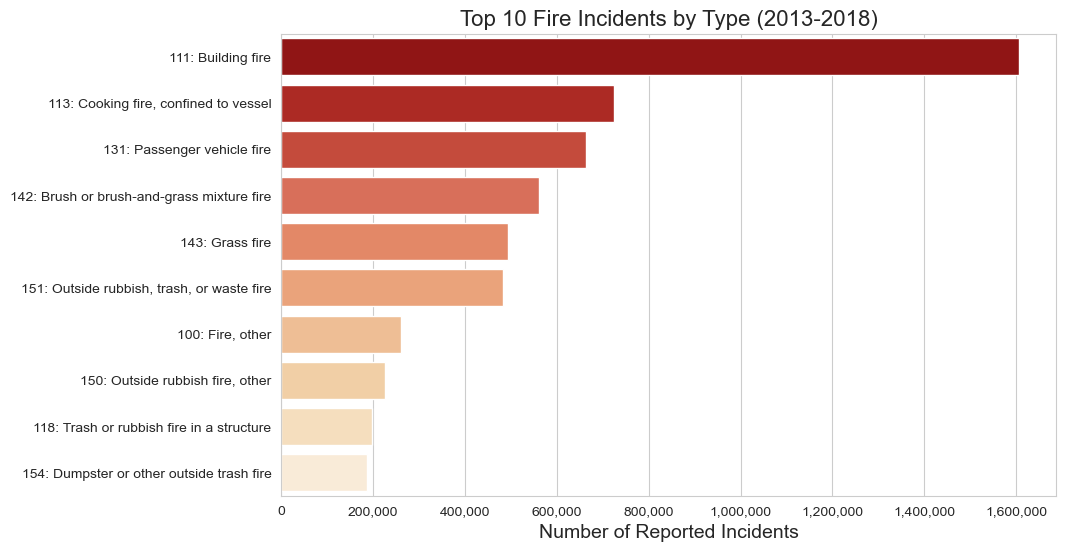

In [9]:
grouped_data = by_type_13_18 \
    .groupby('INC_TYPE')['INC_COUNT'] \
    .sum() \
    .reset_index()
sorted_data = grouped_data.sort_values('INC_COUNT', ascending=False)

# Avoid copy warning
top_10 = sorted_data.head(10).copy()

descriptions = {
    111: 'Building fire',
    113: 'Cooking fire, confined to vessel',
    131: 'Passenger vehicle fire',
    151: 'Outside rubbish, trash, or waste fire',
    142: 'Brush or brush-and-grass mixture fire',
    143: 'Grass fire',
    150: 'Outside rubbish fire, other',
    100: 'Fire, other',
    118: 'Trash or rubbish fire in a structure',
    154: 'Dumpster or other outside trash fire',
}

top_10.loc[:, 'INC_TYPE_DESC'] = top_10['INC_TYPE'].map(descriptions)
top_10.loc[:, 'INC_TYPE_WITH_DESC'] = top_10['INC_TYPE'].astype(str) + ': ' + top_10['INC_TYPE_DESC']

top_10 = top_10.sort_values('INC_COUNT', ascending=False)

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
palette = sns.color_palette("OrRd_r", len(top_10))
sns.barplot(y=top_10['INC_TYPE_WITH_DESC'], x=top_10['INC_COUNT'], palette=palette, ax=ax)
ax.set_xlabel('Number of Reported Incidents', fontsize=14)
ax.set_ylabel('')
ax.set_title('Top 10 Fire Incidents by Type (2013-2018)', fontsize=16)

# Create a function to format x-axis ticks
comma_format = FuncFormatter(lambda x, p: format(int(x), ','))
ax.xaxis.set_major_formatter(comma_format)
plt.show()

Let's get total incident counts for each city for each of the top five types of incidents.

In [10]:
incident_types = [111, 113, 131, 151, 142]

top_5 = by_type_13_18[by_type_13_18['INC_TYPE'].isin(incident_types)].pivot_table(
    index=['CITYSTATE'], columns='INC_TYPE', values='INC_COUNT', fill_value=0
)

top_5.reset_index(inplace=True)
top_5.columns = top_5.columns.to_flat_index()

top_5.columns = [
    'CITYSTATE', 
    'COUNT_111', 
    'COUNT_113', 
    'COUNT_131', 
    'COUNT_151', 
    'COUNT_142'
]
top_5.sample(n=3, random_state=1)

,CITYSTATE,COUNT_111,COUNT_113,COUNT_131,COUNT_151,COUNT_142
51283,"SMITH GROVE,KY",8,0,3,11,1
47255,"RIGATOWNSHIP OF,ND",0,0,0,1,0
13412,"COSSAYUNA,NY",4,0,1,2,0


Now let's export for future analysis.

In [11]:
top_5.to_csv(
    WORKING_DIRECTORY + 'processed/top5_by_type_13_18.csv',
    sep=',',
    index=False
)